# EMアルゴリズム
## 混合ガウス分布（EMアルゴリズム）を理解する
参考サイト [EMアルゴリズム徹底解説](https://qiita.com/kenmatsu4/items/59ea3e5dfa3d4c161efb)

In [1]:
import os
import numpy as np
import numpy.random as rd
import scipy as sp
from scipy import stats as st
from collections import Counter

import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc
import matplotlib.animation as ani
plt.rcParams["patch.force_edgecolor"] = True
#rc('text', usetex=True)
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]
%matplotlib inline

# %config InlineBackend.figure_format='retina'
# OS判別 ======================
flag_win32 = False
try:
    os.uname()
except AttributeError:
    flag_win32 = True

# Mac用フォント設定（yasubeiの環境では上手く行かなかったのでコメントアウトしておきます）
# if not flag_win32:
#     font_path = '/Library/Fonts/Osaka.ttf'
#     font_prop = font_manager.FontProperties(fname=font_path)
#     matplotlib.rcParams['font.family'] = font_prop.get_name()
#     plt.rcParams['font.family'] = 'Osaka'


In [2]:
# 定数定義
GMM_GIF = "image/gmm_anim.gif"

In [3]:
def calc_likelihood(data, mu, sigma, pi, K):
    likelihood = np.zeros((np.sum(n), 3))
    for k in range(K):
        likelihood[:, k] = [pi[k]*st.multivariate_normal.pdf(d, mu[k], sigma[k]) for d in data]
    return likelihood

def calc_prob_gmm(data, mu, sigma, pi, K):
    return [[pi[k]*st.multivariate_normal.pdf(d, mu[k], sigma[k]) for k in range(K)] for d in data]

def print_gmm_contour(mu, sigma, pi, K):
    # display predicted scores by the model as a contour plot
    X, Y = np.meshgrid(np.linspace(min_x, max_x), np.linspace(min_y, max_y))
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = np.sum(np.asanyarray(calc_prob_gmm(XX, mu, sigma, pi, K)), axis=1)
    Z = Z.reshape(X.shape)
    CS = plt.contour(X, Y, Z, alpha=0.2, zorder=-100)
    
    plt.title('pdf contour of a GMM')

check:  0 [0.2 0.5] [[0.1   0.085]
 [0.085 0.1  ]] 0.0027750000000000014
check:  1 [1.2 0.5] [[ 0.1   -0.085]
 [-0.085  0.1  ]] 0.0027750000000000014
check:  2 [2.  0.5] [[0.1   0.085]
 [0.085 0.1  ]] 0.0027750000000000014


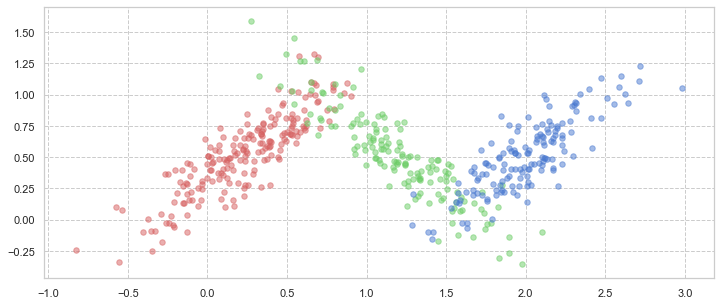

In [4]:
seed = 77
D = 2
n = [200, 150, 150]
N = np.sum(n)
mu_true = np.asanyarray(
     [[0.2, 0.5],
      [1.2, 0.5],
      [2.0, 0.5]])

D = mu_true.shape[1]

sigma_true = np.asanyarray(
        [ [[0.1,  0.085],[ 0.085, 0.1]],
          [[0.1, -0.085],[-0.085, 0.1]],
          [[0.1,  0.085],[ 0.085, 0.1]]
        ])
c = ['r', 'g', 'b']

rd.seed(seed)
org_data = None #np.empty((np.sum(n), 3))
for i in range(3):
    print("check: ", i, mu_true[i], sigma_true[i], np.linalg.det(sigma_true[i]))
    #org_data.append(st.multivariate_normal.rvs(mean=mu[i], cov=sigma[i], size=n[i]))
    if org_data is None:
        org_data = np.c_[st.multivariate_normal.rvs(mean=mu_true[i], cov=sigma_true[i], size=n[i]), np.ones(n[i])*i]
    else:
        org_data = np.r_[org_data, np.c_[st.multivariate_normal.rvs(mean=mu_true[i], 
                                                                    cov=sigma_true[i], 
                                                                    size=n[i]), np.ones(n[i])*i]]
        
# plot generated data        

plt.figure(figsize=(12, 5))
for i in range(3):
    plt.scatter(org_data[org_data[:,2]==i][:,0], org_data[org_data[:,2]==i][:,1], s=30, c=c[i], alpha=0.5)
    
# drop true cluster label
data = org_data[:,0:2].copy()

# Initialize

init pi: [0.33333333 0.33333333 0.33333333]
init mu:
 [[-0.71120253  0.46747188]
 [ 0.72953472 -0.17640641]
 [ 2.89854431 -0.00454181]]


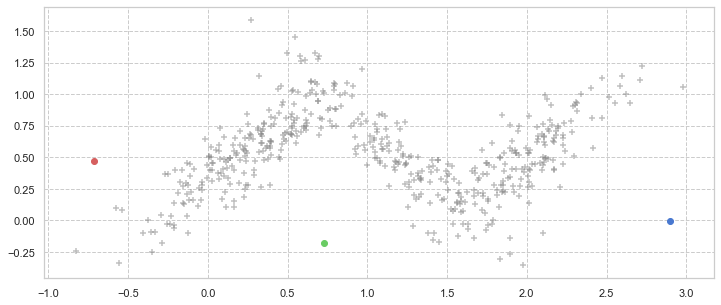

initial sum of log likelihood: -25067.19980437461
pi:
 [0.33333333 0.33333333 0.33333333]
mu:
 [[-0.71120253  0.46747188]
 [ 0.72953472 -0.17640641]
 [ 2.89854431 -0.00454181]]
sigma:
 [[[0.1 0. ]
  [0.  0.1]]

 [[0.1 0. ]
  [0.  0.1]]

 [[0.1 0. ]
  [0.  0.1]]]


Text(0.5, 1.0, 'initial state')

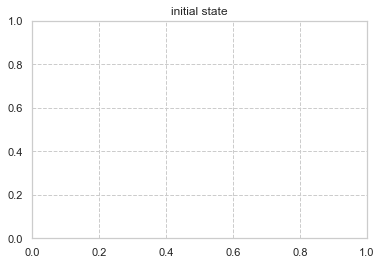

In [10]:

# initialize pi
K = 3
pi = np.zeros(K)
for k in range(K):
    if k == K-1:
        pi[k] = 1 - np.sum(pi)
    else:
        pi[k] = 1/K
print('init pi:', pi)

# initialize mu
max_x, min_x = np.max(data[:,0]), np.min(data[:,0])
max_y, min_y = np.max(data[:,1]), np.min(data[:,1])
mu = np.c_[rd.uniform(low=min_x, high=max_x, size=K), rd.uniform(low=min_y, high=max_y, size=K) ]
print('init mu:\n', mu)

# visualize for check
#plt.figure(figsize=(12,8))
plt.figure(figsize=(12, 5))
plt.scatter(data[:,0], data[:,1], s=30, c='gray', alpha=0.5, marker="+")

for i in range(3):
    plt.scatter([mu[i, 0]], [mu[i, 1]], c=c[i], marker='o')
    
plt.show()

# initialize sigma
sigma = np.asanyarray(
        [ [[0.1,  0],[ 0, 0.1]],
          [[0.1,  0],[ 0, 0.1]],
          [[0.1,  0],[ 0, 0.1]] ])

# calculate likelihood
likelihood = calc_likelihood(data, mu, sigma, pi, K)
print('initial sum of log likelihood:', np.sum(np.log(likelihood)))

print('pi:\n', pi)
print('mu:\n', mu)
print('sigma:\n', sigma)

plt.title('initial state')

# EM algorithm started

In [11]:
#for step in range(100):
def animate(nframe):
    global mu, sigma, pi
    print('nframe:', nframe)
    plt.clf()
    
    if nframe <= 3:
        print('initial state')
        plt.scatter(data[:,0], data[:,1], s=30, c='gray', alpha=0.5, marker="+")
        for i in range(3):
            plt.scatter([mu[i, 0]], [mu[i, 1]], c=c[i], marker='o', edgecolors='k', linewidths=1)
        print_gmm_contour(mu, sigma, pi, K)
        plt.title('initial state')
        return

    # E step ========================================================================
    # calculate responsibility(負担率)
    likelihood = calc_likelihood(data, mu, sigma, pi, K)
    #gamma = np.apply_along_axis(lambda x: [xx/np.sum(x) for xx in x] , 1, likelihood)
    gamma = (likelihood.T/np.sum(likelihood, axis=1)).T
    N_k = [np.sum(gamma[:,k]) for k in range(K)]

    # M step ========================================================================

    # caluculate pi
    pi =  N_k/N

    # calculate mu
    tmp_mu = np.zeros((K, D))

    for k in range(K):
        for i in range(len(data)):
            tmp_mu[k] += gamma[i, k]*data[i]
        tmp_mu[k] = tmp_mu[k]/N_k[k]
        #print('updated mu[{}]:\n'.format(k) , tmp_mu[k])
    mu_prev = mu.copy()
    mu = tmp_mu.copy()
    #print('updated mu:\n', mu)

    # calculate sigma
    tmp_sigma = np.zeros((K, D, D))

    for k in range(K):
        tmp_sigma[k] = np.zeros((D, D))
        for i in range(N):
            tmp = np.asanyarray(data[i]-mu[k])[:,np.newaxis]
            tmp_sigma[k] += gamma[i, k]*np.dot(tmp, tmp.T)
        tmp_sigma[k] = tmp_sigma[k]/N_k[k]

        #print('updated sigma[{}]:\n'.format(k) , tmp_sigma[k])
    sigma = tmp_sigma.copy()

    # calculate likelihood
    prev_likelihood = likelihood
    likelihood = calc_likelihood(data, mu, sigma, pi, K)
    
    prev_sum_log_likelihood = np.sum(np.log(prev_likelihood))
    sum_log_likelihood = np.sum(np.log(likelihood))
    diff = prev_sum_log_likelihood - sum_log_likelihood
    
    print('sum of log likelihood:', sum_log_likelihood)
    print('diff:', diff)

    print('pi:', pi)
    print('mu:', mu)
    print('sigma:', sigma)

    # visualize
    #plt.figure(figsize=(12,8))
    for i in range(N):
        plt.scatter(data[i,0], data[i,1], s=30, c=[gamma[i]], alpha=0.5, marker="+")

    for i in range(K):
        ax = plt.axes()
        ax.arrow(mu_prev[i, 0], mu_prev[i, 1], mu[i, 0]-mu_prev[i, 0], mu[i, 1]-mu_prev[i, 1],
                  lw=0.8, head_width=0.02, head_length=0.02, fc='k', ec='k')
        plt.scatter([mu_prev[i, 0]], [mu_prev[i, 1]], c=c[i], marker='o', alpha=0.8)
        plt.scatter([mu[i, 0]], [mu[i, 1]], c=c[i], marker='o', edgecolors='k', linewidths=1)
        #plt.scatter([mu[i, 0]], [mu[i, 1]], c=c[i], marker='o')
    plt.title("step:{}".format(nframe))
    
    print_gmm_contour(mu, sigma, pi, K)
    # plt.show()
    
    if np.abs(diff) < 0.0001:
        plt.title('likelihood is converged.')
    else:
        plt.title("iter:{}".format(nframe-3))

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


nframe: 0
initial state
nframe: 0
initial state
nframe: 1
initial state
nframe: 2
initial state
nframe: 3
initial state
nframe: 4
sum of log likelihood: -38623.790414177216
diff: 13556.590609802606
pi: [0.17496367 0.57784893 0.24718739]
mu: [[-0.00295322  0.4018132 ]
 [ 0.92271473  0.53494344]
 [ 2.09542303  0.55850129]]
sigma: [[[ 0.07010449  0.07894322]
  [ 0.07894322  0.12443933]]

 [[ 0.26597926 -0.07203996]
  [-0.07203996  0.09920361]]

 [[ 0.05387613  0.04811045]
  [ 0.04811045  0.0858957 ]]]


/Users/suzuki_yasuharu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


nframe: 5
sum of log likelihood: -38963.61503481839
diff: 339.82462064117135
pi: [0.21433974 0.52724945 0.25841081]
mu: [[0.04111007 0.39680716]
 [0.96868252 0.55776166]
 [2.05520168 0.53535925]]
sigma: [[[ 0.07533084  0.07661236]
  [ 0.07661236  0.10532145]]

 [[ 0.25732503 -0.0892519 ]
  [-0.0892519   0.10275497]]

 [[ 0.07042079  0.06317976]
  [ 0.06317976  0.08688097]]]
nframe: 6
sum of log likelihood: -36872.81189957577
diff: -2090.8031352426187
pi: [0.26092815 0.46544866 0.27362319]
mu: [[0.08886806 0.42002811]
 [1.01537951 0.5720738 ]
 [2.02775197 0.51752028]]
sigma: [[[ 0.07893075  0.07290371]
  [ 0.07290371  0.09296787]]

 [[ 0.23048256 -0.10127471]
  [-0.10127471  0.10914961]]

 [[ 0.07939885  0.07033896]
  [ 0.07033896  0.08893854]]]
nframe: 7
sum of log likelihood: -35155.337371450565
diff: -1717.4745281252035
pi: [0.30364592 0.41140621 0.28494787]
mu: [[0.13047225 0.444766  ]
 [1.06301308 0.57730923]
 [2.01330729 0.50856217]]
sigma: [[[ 0.0836565   0.07233848]
  [ 0.072338

nframe: 27
sum of log likelihood: -38831.34373090972
diff: 0.012513015550212003
pi: [0.39593115 0.29328056 0.31078829]
mu: [[0.2229891  0.51729538]
 [1.17045209 0.53905183]
 [1.99195406 0.49733827]]
sigma: [[[ 0.09987298  0.08195587]
  [ 0.08195587  0.09101233]]

 [[ 0.12168678 -0.11849002]
  [-0.11849002  0.13718178]]

 [[ 0.08604215  0.07103668]
  [ 0.07103668  0.08601496]]]
nframe: 28
sum of log likelihood: -38831.35086366611
diff: 0.007132756392820738
pi: [0.3959316  0.29328004 0.31078836]
mu: [[0.22298959 0.51729594]
 [1.17045277 0.53905118]
 [1.99195396 0.49733821]]
sigma: [[[ 0.0998731   0.08195601]
  [ 0.08195601  0.09101253]]

 [[ 0.12168651 -0.11848983]
  [-0.11848983  0.13718163]]

 [[ 0.08604218  0.07103669]
  [ 0.07103669  0.08601496]]]
nframe: 29
sum of log likelihood: -38831.35492159358
diff: 0.0040579274646006525
pi: [0.39593184 0.29327976 0.3107884 ]
mu: [[0.22298987 0.51729625]
 [1.17045315 0.53905082]
 [1.99195391 0.49733818]]
sigma: [[[ 0.09987317  0.0819561 ]
  [ 0

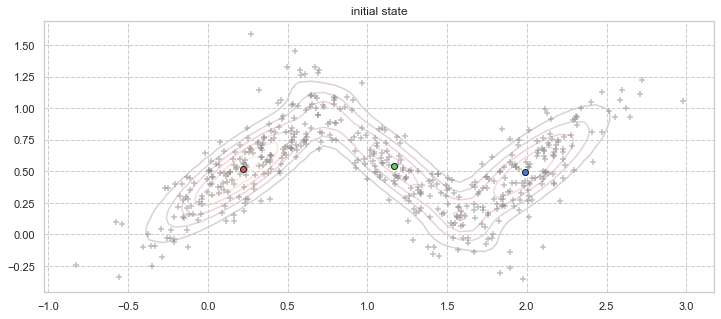

In [12]:
fig = plt.figure(figsize=(12,5))
anim = ani.FuncAnimation(fig, animate, frames=48)
anim.save(GMM_GIF, writer='imagemagick', fps=3, dpi=128)

Text(0.5, 1.0, 'pdf contour of a GMM')

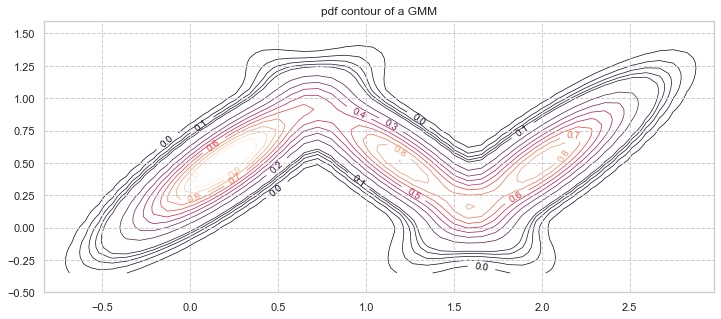

In [13]:
mu_true = np.asanyarray(
     [[0.2, 0.5],
      [1.2, 0.5],
      [2.0, 0.5]])

sigma_true = np.asanyarray(
        [ [[0.1,  0.085],[ 0.085, 0.1]],
          [[0.1, -0.085],[-0.085, 0.1]],
          [[0.1,  0.085],[ 0.085, 0.1]]
        ])


plt.figure(figsize=(12, 5))
X, Y = np.meshgrid(np.linspace(min_x, max_x), np.linspace(min_y, max_y))
XX = np.array([X.ravel(), Y.ravel()]).T
Z = np.sum(np.asanyarray(calc_prob_gmm(XX, mu_true, sigma_true, np.array(n)/N, K)), axis=1)
Z = Z.reshape(X.shape)
levels = np.r_[np.arange(0, 0.1, 0.02),np.arange(0.1, 1.1, 0.1)]
CS = plt.contour(X, Y, Z, alpha=1, zorder=-100, linewidths=0.7, levels=levels)#[0.2, 0.4, 0.8, 1.0])
CS.clabel(fmt='%1.1f', fontsize=10)
plt.ylim(-0.5, 1.6)
plt.title('pdf contour of a GMM')

Text(0.5, 1.0, 'Generated data')

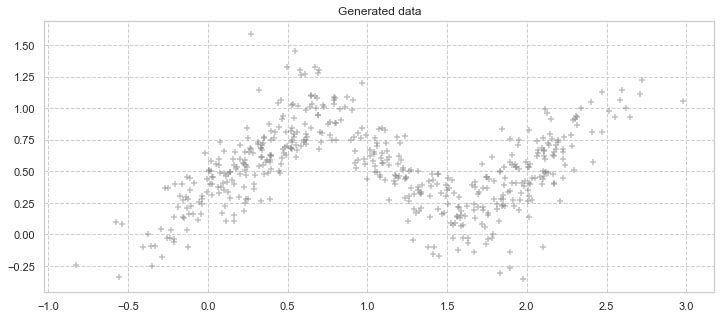

In [14]:

# visualize for check
plt.figure(figsize=(12, 5))
plt.scatter(data[:,0], data[:,1], s=30, c='gray', alpha=0.5, marker="+")
plt.title('Generated data')

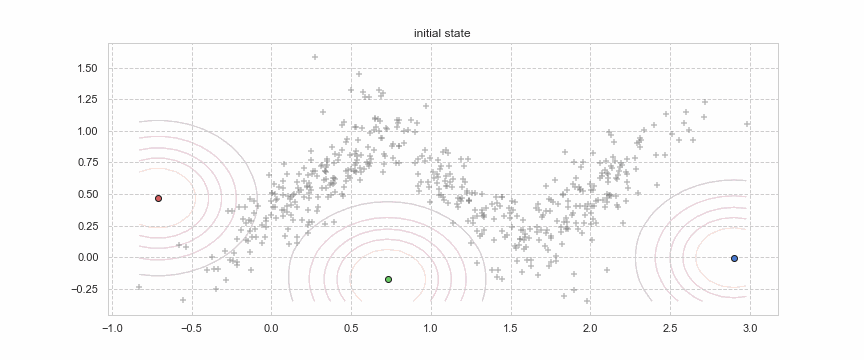

In [15]:
import IPython
IPython.display.Image(GMM_GIF)